# ML_100day Midterm
- [Enron Fraud Dataset 安隆公司詐欺案資料集](https://www.kaggle.com/competitions/2021-ml100marathon-midterm)

## Step1 找出問題
- 這個問題是如何產生的？安隆公司曾是間能源公司，卻於2002年宣告破產，揭露其財報造假的醜聞，而本次的問題在於找出可疑的詐欺犯  
- 它提供了哪些資訊、資料與變數？薪水、獎金、長期獎勵、延期收入/付款、貨代墊款、董事費、股票價值等等   
- 這個問題的預期產出是什麼？找出可疑的詐欺犯罪者(Person of Interest,POI)  
- 會對這個問題可以產生什麼結果？同上    

### 用什麼方法？
- 該問題是監督還是非監督學習？監督式學習  
- 該問題的結果是分類還是回歸？分類

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Step2 Train / Test 資料集

In [2]:
# Load Data
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_features.csv")
df_sample = pd.read_csv('sample_submission.csv')

In [3]:
# train data
df_train.shape

(113, 22)

In [4]:
# test data
df_test.shape

(33, 21)

In [5]:
# 答案範例
df_sample.head()

,name,poi
0,BELDEN TIMOTHY N,0.007201
1,BOWEN JR RAYMOND M,0.903340
2,HANNON KEVIN P,0.572731
3,DELAINEY DAVID W,0.950927
4,CAUSEY RICHARD A,0.942402


## Step3 進行探索式資料分析(EDA)
EDA (Exploratory Data Analysis)  
- 確認資料狀況
- 樞紐分析與視覺化

### A. 確認資料狀況
- 檢視欄位的種類
- 檢視資料的型態：名目/類別屬性、次序/順序屬性、等距/區間屬性、比率/比例屬性
- 檢視錯誤與分布  

In [6]:
# test data 和 train data差異 : 沒有poi欄位
train_Y = df_train['poi'] # 找出target
df_train = df_train.drop(['poi'], axis=1) # 從train data drop target
df = pd.concat([df_train, df_test], axis=0) # 合併train/test data
print(df.shape)
df.head()

(146, 21)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [8]:
# 檢查 df 空缺值
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing 比例' :data_na})
    display(missing_data.head(20))
na_check(df)

,Missing 比例
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_messages,41.095890
from_poi_to_this_person,41.095890
from_this_person_to_poi,41.095890


### 資料狀況筆記
- 除了```name```欄位外, 其餘所有欄位都有缺失值   
- 缺失值太多的欄位, 如: ```loan_advances```, ```director_fees```, ```restricted_stock_deferred```,```deferral_payments``` 可考慮移除

### B. 樞紐分析與視覺化
1. 檢視資料的分布
2. 樞紐分析與圖例

In [9]:
# email紀錄
email_features = ["from_messages", "from_poi_to_this_person", "from_this_person_to_poi", "shared_receipt_with_poi", "to_messages"]
df[email_features].head()

,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages
0,18.0,42.0,4.0,864.0,905.0
1,108.0,88.0,30.0,2042.0,3627.0
2,39.0,13.0,14.0,91.0,225.0
3,NaN,NaN,NaN,NaN,NaN
4,144.0,199.0,25.0,2188.0,2598.0


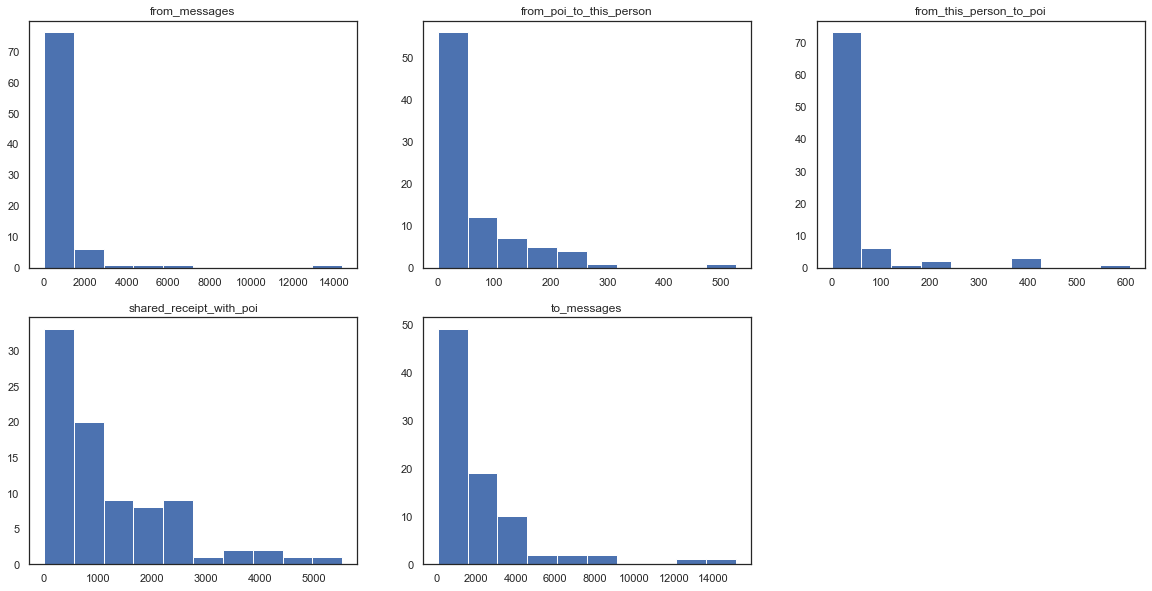

In [10]:
sns.set(style="white")
plt.figure(figsize=(20,10))
for i in range(len(email_features)):
    plt.subplot(2,3,i+1)
    plt.hist(df[email_features[i]])
    plt.title(str(email_features[i]))
plt.show()

In [11]:
# stock相關的 特徵
stock_features=["exercised_stock_options","restricted_stock","restricted_stock_deferred","total_stock_value"]
df[stock_features].head()

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
0,19794175.0,2748364.0,NaN,22542539.0
1,19250000.0,6843672.0,NaN,26093672.0
2,1624396.0,869220.0,NaN,2493616.0
3,NaN,985032.0,NaN,985032.0
4,NaN,126027.0,NaN,126027.0


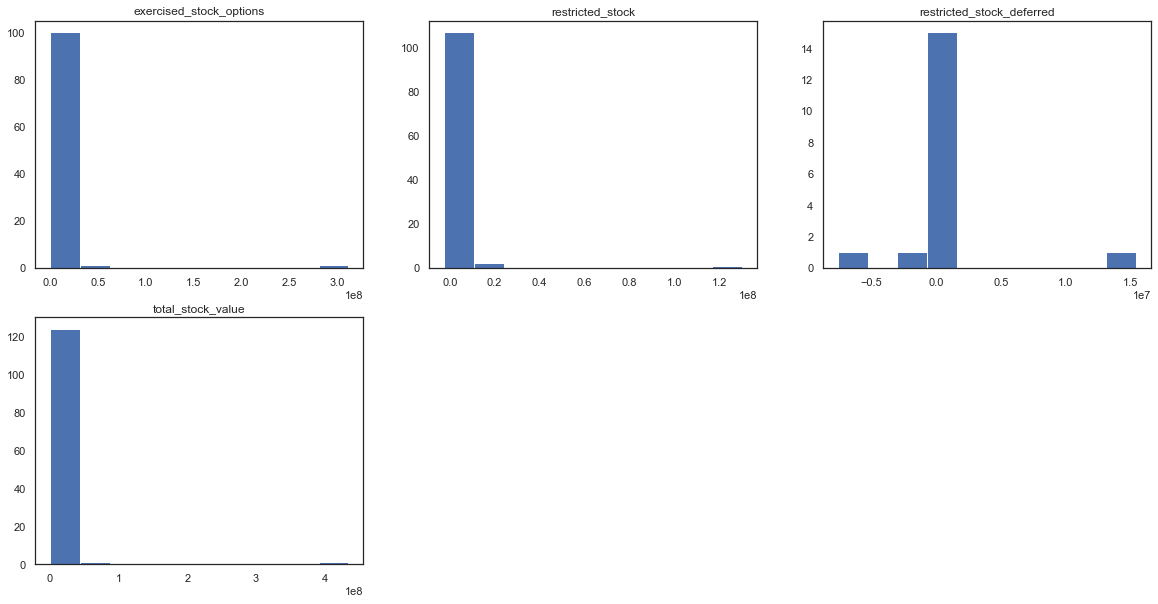

In [12]:
sns.set(style="white")
plt.figure(figsize=(20,10))
for i in range(len(stock_features)):
    plt.subplot(2,3,i+1)
    plt.hist(df[stock_features[i]])
    plt.title(str(stock_features[i]))
plt.show()

In [13]:
# Payments相關特徵
payment_features=["bonus","deferral_payments","deferred_income","director_fees","expenses",
                 "loan_advances","long_term_incentive","other","salary","total_payments"]
df[payment_features].head()

,bonus,deferral_payments,deferred_income,director_fees,expenses,loan_advances,long_term_incentive,other,salary,total_payments
0,1750000.0,NaN,-3504386.0,NaN,46950.0,NaN,1617011.0,174839.0,420636.0,505050.0
1,5600000.0,NaN,NaN,NaN,29336.0,NaN,1920000.0,22122.0,1111258.0,8682716.0
2,200000.0,NaN,-4167.0,NaN,22884.0,NaN,NaN,1573324.0,211844.0,2003885.0
3,800000.0,NaN,NaN,NaN,118134.0,NaN,602671.0,907502.0,224305.0,2652612.0
4,1250000.0,NaN,-262500.0,NaN,35818.0,NaN,375304.0,486.0,240189.0,1639297.0


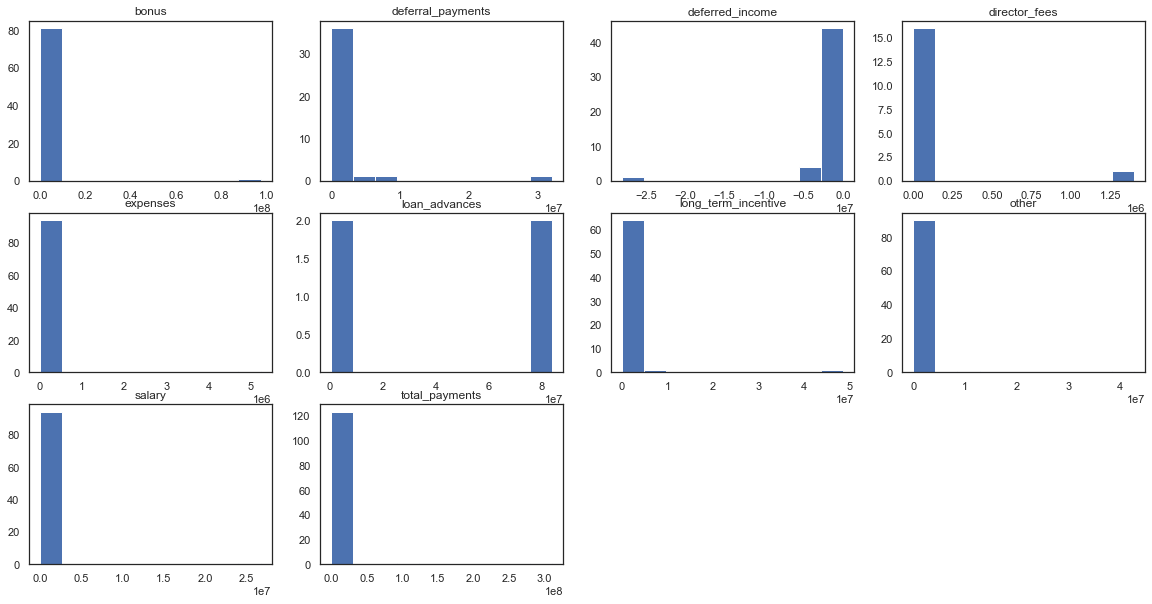

In [14]:
plt.figure(figsize=(20,10))
for i in range(len(payment_features)):
    plt.subplot(3,4,i+1)
    plt.hist(df[payment_features[i]])
    plt.title(str(payment_features[i]))
plt.show()

## 可以看到不管是message/stock/payment都有偏態的狀況，需要做"去除偏態"

## Step4 清理資料

### A. 檢查資料與確認缺失值
1. 是否有遺漏值/缺失值 (Missing value):  
* 除了```name```之外，其餘都有缺失值，缺失值太多的欄位，如: ```loan_advances```, ```director_fees```, ```restricted_stock_deferred```,```deferral_payments``` 考慮移除</font>   
2. 是否有極值或異常值 (Outlier)  
* 從柱狀圖來看, 特徵值都呈偏邊分布, 可以進行"去除偏態"處理 (因資料較少,為避免移除不該移除的資料的做法)</font>  
3. 資料分布是否符合常態 (Normal Distribution): 
* 不是，都有偏態
4. 資料是否需要清洗 (Clean Data)    
* ```email_address```可調整為 有資料:1, 缺失值:0</font>    

### B. 進行資料加工
1. DataFrame.copy() 先複製出一份新的資料  
2. 移除缺失值太多的欄位```loan_advances```, ```director_fees```, ```restricted_stock_deferred```,```deferral_payments```和```name```
3. 剩餘缺失值欄位: 以```fillna(0)```填補後, 除了email_address, 其餘使用log去偏態
4. ```email_address```有資料補1, 缺失值維持0
5. 完成後, 確認缺失值與目前的資料表內容

In [16]:
#1. 複製出一份新的資料
df_copy = df.copy()

#2. 移除缺失值太多的欄位
df_copy = df_copy.drop(["loan_advances", "director_fees", "restricted_stock_deferred", "deferral_payments", "name"],axis=1)

#3. 剩餘缺失值欄位: 以fillna(0)填補，其餘使用log去偏態
df_copy = df_copy.fillna(0)
df_email = df_copy["email_address"]
df_copy = df_copy.drop(["email_address"], axis=1)

for i in list(df_copy.columns):
    df_copy[i] = df_copy[i].map(lambda i: np.log(i) if i > 0 else 0)

#4. 有資料補1，缺失值維持0
df_email = df_email.apply(lambda x:1 if x!=0 else 0)
df_copy["email_address"] = df_email

#5. 確認缺失值與目前的資料表內容
na_check(df_copy)
print(df_copy.shape)
df_copy.head()

,Missing 比例


(146, 16)


,bonus,deferred_income,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,email_address
0,14.375126,0,16.800898,10.756838,2.890372,3.737670,1.386294,14.296090,12.071621,14.826516,12.949523,6.761573,6.807935,13.132413,16.930915,1
1,15.538277,0,16.773022,10.286571,4.682131,4.477337,3.401197,14.467836,10.004328,15.738835,13.921003,7.621685,8.196161,15.976845,17.077203,1
2,12.206073,0,14.300647,10.038193,3.663562,2.564949,2.639057,0.000000,14.268701,13.675352,12.263605,4.510860,5.416100,14.510598,14.729244,1
3,13.592367,0,0.000000,11.679575,0.000000,0.000000,0.000000,13.309127,13.718451,13.800429,12.320762,0.000000,0.000000,14.791055,13.800429,1
4,14.038654,0,0.000000,10.486206,4.969813,5.293305,3.218876,12.835492,6.186209,11.744251,12.389181,7.690743,7.862497,14.309778,11.744251,1


## Step5 模型建置與預測 

### A. 特徵預處理 (Preprocessing)
<font color=#008000>使用```標準化```平衡特徵 (標準化轉換較不易受到極端值影響, 若已經使用log去偏態還需使用? 對非樹狀模型才有影響)</font>

In [18]:
from sklearn.preprocessing import StandardScaler
df_copy = StandardScaler().fit_transform(df_copy)

### B. 準備訓練／測試集 (Train / Test Split)

In [19]:
# 將df_work , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df_copy[:train_num]
test_X = df_copy[train_num:]

# 區分訓練集與測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=10)

### C. 訓練與評估模型 (Model Training)
固定random_state=10做預測
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. Logistic Regression

In [21]:
lr = LogisticRegression(random_state=10)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:",accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.8823529411764706


# 2. Decision Tree

In [32]:
dt = DecisionTreeClassifier(random_state=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Decision Tree(未調整參數) Accuracy:", accuracy_score(y_test, y_pred))

Decision Tree(未調整參數) Accuracy: 0.8823529411764706


In [28]:
# 調整參數
max_depths = list(range(1,21))
min_samples_splits = list(range(1,21))
min_samples_leaves = list(range(1,21))
param_grid = {"max_depth":max_depths,"min_samples_split":min_samples_splits, "min_samples_leaf":min_samples_leaves}

dt_rscv = RandomizedSearchCV(dt, param_grid, scoring="accuracy", random_state=10, n_jobs=-1)
search_result = dt_rscv.fit(X_train, y_train)
print("Best Accuracy:" ,search_result.best_score_, search_result.best_params_)

Best Accuracy: 0.9116666666666667 {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 4}


In [33]:
dt_bestparam = dt_rscv.best_estimator_
dt_bestparam.fit(X_train, y_train)
y_pred = dt_bestparam.predict(X_test)
print("Decision Tree(已調整參數) Accuracy:", accuracy_score(y_test, y_pred))

Decision Tree(已調整參數) Accuracy: 0.9117647058823529


In [30]:
dt_pred = dt_bestparam.predict_proba(test_X)[:,1]
sub = pd.DataFrame({"name": df_test["name"], "poi": dt_pred})
sub.to_csv("poi_decision_tree.csv", index=False)

# 3. Random Forest

In [34]:
#3. Random Forest
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest(未調整參數) Accuracy:", accuracy_score(y_test, y_pred))

Random Forest(未調整參數) Accuracy: 0.9117647058823529


In [35]:
# 調整參數
n_estimators = list(range(5,105,5))
max_depths = list(range(1,21))
min_samples_splits = list(range(1,21))
min_samples_leaves = list(range(1,21))
param_grid = {"n_estimators":n_estimators,"max_depth":max_depths,
              "min_samples_split":min_samples_splits,"min_samples_leaf":min_samples_leaves}

rf_rscv = RandomizedSearchCV(rf, param_grid, scoring="accuracy", random_state=10, n_jobs=-1)
search_result = rf_rscv.fit(X_train, y_train)
print("Best Accuracy:", search_result.best_score_, search_result.best_params_)

Best Accuracy: 0.8866666666666667 {'n_estimators': 80, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_depth': 12}


In [36]:
rf_bestparam = rf_rscv.best_estimator_
rf_bestparam.fit(X_train, y_train)
y_pred = rf_bestparam.predict(X_test)
print("Random Forest(已調整參數) Accuracy:", accuracy_score(y_test, y_pred))

Random Forest(已調整參數) Accuracy: 0.8823529411764706


In [37]:
rf_pred = rf_bestparam.predict_proba(test_X)[:,1]
sub = pd.DataFrame({"name": df_test["name"], "poi": rf_pred})
sub.to_csv("poi_random_forest.csv", index=False)

# 4. Gradient Boosting

In [38]:
gb = GradientBoostingClassifier(random_state=10)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("Gradient Boosting(未調整參數) Accuracy:", accuracy_score(y_test, y_pred))

Gradient Boosting(未調整參數) Accuracy: 0.8529411764705882


In [43]:
# 調整參數
n_estimators = list(range(5,105,5))
max_depths = list(range(1,21))
min_samples_splits = list(range(1,21))
min_samples_leaves = list(range(1,21))
param_grid = {"n_estimators":n_estimators,"max_depth":max_depths,
              "min_samples_split":min_samples_splits,"min_samples_leaf":min_samples_leaves}

gb_rscv = RandomizedSearchCV(gb, param_grid, scoring="accuracy", random_state=10, n_jobs=-1)
search_result = gb_rscv.fit(X_train, y_train)
print("Best Accuracy:", search_result.best_score_, search_result.best_params_)

Best Accuracy: 0.8991666666666667 {'n_estimators': 65, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 2}


In [44]:
gb_bestparam = gb_rscv.best_estimator_
gb_bestparam.fit(X_train, y_train)
y_pred = gb_bestparam.predict(X_test)
print("Gradient Boosting(已調整參數) Accuracy:", accuracy_score(y_test, y_pred))

Gradient Boosting(已調整參數) Accuracy: 0.8823529411764706


In [45]:
gb_pred = gb_bestparam.predict_proba(test_X)[:,1]
sub = pd.DataFrame({"name": df_test["name"], "poi": gb_pred})
sub.to_csv("poi_gradient_boosting.csv", index=False)

# Blending

In [49]:
blending_pred = dt_pred*0.3 + rf_pred*0.4 + gb_pred*0.3
sub = pd.DataFrame({"name": df_test["name"], "poi": blending_pred})
sub.to_csv("poi_blending.csv", index=False)

# Stacking

In [50]:
from mlxtend.classifier import StackingClassifier
meta_estimator = rf_bestparam
stacking = StackingClassifier(classifiers=[dt_bestparam, rf_bestparam, gb_bestparam], meta_classifier=meta_estimator, 
                              use_probas=True, average_probas=False)
stacking.fit(train_X, train_Y)
stacking_pred = stacking.predict_proba(test_X)[:,1]
sub = pd.DataFrame({"name": df_test["name"], "poi": stacking_pred})
sub.to_csv("poi_stacking.csv", index=False)

<img src = "./midterm.jpg">